# Transfer Learning and Fine Tuning

__Before starting, we recommend you enable GPU acceleration if you're running on Colab.__

In [179]:
# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

try: 
    import torchbearer
except:
    !pip install torchbearer

## Getting started 

Start by downloading and unzipping the data set. The code in the following block will download and unzip the data we're going to use.

In [180]:
from os.path import exists
if not exists('data'):
  !wget -O boat-data.zip https://artist-cloud.ecs.soton.ac.uk/index.php/s/eAhIkhhdxgmhRHj/download
  !unzip -q boat-data.zip

We'll start by exploring the data, and look at how we can get that data loaded into memory through python code. We can just use the `ls` command from with this notebook to explore the data set:

In [181]:
!ls data
!ls data/test

mf.jpg	README.md  test  train	valid
Alilaguna  Lanciafino10m	    Mototopo	     Sandoloaremi
Ambulanza  Motobarca		    Patanella	     Topa
Barchino   Motopontonerettangolare  Polizia	     VaporettoACTV
Gondola    MotoscafoACTV	    Raccoltarifiuti  Water


If you explore the `data` directory you should see three folders:

	- The `train` folder contains the training data & is broken into subdirectories for each class. 
	- The `valid` folder contains the validation data & is broken into subdirectories for each class. 
	- The `test` folder contains the testing data & is broken into subdirectories for each class. 
    
The following displays one of the images:

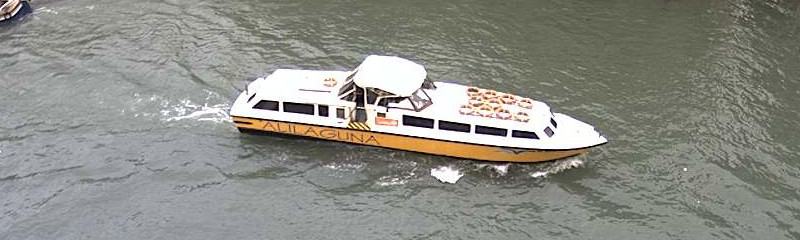

In [4]:
from IPython.display import Image
Image("data/test/Alilaguna/20130412_064059_20202.jpg")

The `torchvision` library has support for directly reading images from a directory structure like the one we have using the `torchvision.datasets.ImageFolder` class. In addition to loading the images directly, `torchvision` provides a mechanism to dynamically augment the data being read by applying random transformations (flipping, rotating, etc), as well as cropping and scaling the images. The following code will generate a visualisation of the first batch of images produced by the data loader:

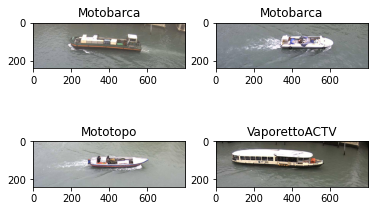

In [5]:
%matplotlib inline

# Plot ad hoc data instances
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms 
import matplotlib
import matplotlib.pyplot as plt
import numpy

transform = transforms.Compose([
    transforms.Resize((240, 800)),
    transforms.ToTensor()  # convert to tensor
])

train_dataset = ImageFolder("data/train", transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# generate the first batch
(batch_images, batch_labels) = train_loader.__iter__().__next__()

# plot 4 images
plt.subplot(221).set_title(train_dataset.classes[batch_labels[0]])
plt.imshow(batch_images[0].permute(1, 2, 0), aspect='equal')
plt.subplot(222).set_title(train_dataset.classes[batch_labels[1]])
plt.imshow(batch_images[1].permute(1, 2, 0), aspect='equal')
plt.subplot(223).set_title(train_dataset.classes[batch_labels[2]])
plt.imshow(batch_images[2].permute(1, 2, 0), aspect='equal')
plt.subplot(224).set_title(train_dataset.classes[batch_labels[3]])
plt.imshow(batch_images[3].permute(1, 2, 0), aspect='equal')

# show the plot
plt.show()

## A simple CNN for boat classification

Now let's try something a little more challenging and take our `BetterCNN` convolutional network from the experiments with mnist last week, and apply it to the problem of boat classification. Firstly we need to setup the data for training, and it would also be sensible to load the validation data to monitor performance during training, as well as load the test data:

In [182]:
# the number of images that will be processed in a single step
batch_size=128
# the size of the images that we'll learn on - we'll shrink them from the original size for speed
image_size=(30, 100)

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()  # convert to tensor
])

train_dataset = ImageFolder("data/train", transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = ImageFolder("data/valid", transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = ImageFolder("data/test", transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Note that for now we're not using any data augmentation from the training data, however we've structured the code so that we can easily add it by manipulating the transforms that are applied. Note that if we dot that, we probably wouldn't want to do the augmentation of the validation/test sets, so we would need a separate set of transforms for those. 

Now we can add the network definition from last week. We'll make a slight change to the previous `BetterCNN` function so that it allows us to specify the number of input channels and the number of output classes in the constructor. In the following block you'll need to paste your implementation of the `BetterCNN` forward method from last week:

In [7]:
import torch 
import torch.nn.functional as F
from torch import nn

# Model Definition
class BetterCNN(nn.Module):
    def __init__(self, n_channels_in, n_classes):
        super(BetterCNN, self).__init__()
        self.conv1 = nn.Conv2d(n_channels_in, 30, (5, 5), padding=0)
        self.conv2 = nn.Conv2d(30, 15, (3, 3), padding=0)
        self.fc1 = nn.Linear(1725, 128)
        self.fc2 = nn.Linear(128, 50)
        self.fc3 = nn.Linear(50, n_classes)
    
    def forward(self, x):
        # YOUR CODE HERE
        out = self.conv1(x) 
        out = F.relu(out)
        out = F.max_pool2d(out, (2,2))

        out = self.conv2(out)
        out = F.relu(out)
        out = F.max_pool2d(out, (2,2))
        
        out = F.dropout(out, 0.2)
        out = out.view(out.shape[0], -1)
        
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        return out
      

We're now in a position to add the code to fit the model - we'll use `torchbearer` to help us out:

In [8]:
import torchbearer
from torchbearer import Trial
from torch import optim
import time

model = BetterCNN(3, len(train_dataset.classes))

# define the loss function and the optimiser
loss_function = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters())

since = time.time()

device = "cuda:0" if torch.cuda.is_available() else "cpu"
trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
trial.with_generators(train_loader, val_generator=val_loader, test_generator=test_loader)
trial.run(epochs=10)

print('time elapsed: ', time.time() - since)

results = trial.evaluate(data_key=torchbearer.VALIDATION_DATA)
print()
print(results)



{'val_loss': 0.6951051354408264, 'val_acc': 0.7113924026489258}


Once the model is trained, we can investigate the performance on the test data. Rather than just look at the average accuracy we need to dig into a little more detail, so we'll use the `classification_report` method in scikit-learn to compute per-class precision and recall values:

In [9]:
predictions = trial.predict()
predicted_classes = predictions.argmax(1).cpu()
true_classes = list(x for (_,x) in test_dataset.samples)

from sklearn import metrics
print(metrics.classification_report(true_classes, predicted_classes, target_names=train_dataset.classes))



                         precision    recall  f1-score   support

              Alilaguna       0.50      0.63      0.56        19
              Ambulanza       0.11      0.14      0.12        22
               Barchino       0.00      0.00      0.00        51
                Gondola       0.00      0.00      0.00         3
          Lanciafino10m       0.00      0.00      0.00         7
              Motobarca       0.18      0.14      0.15        59
Motopontonerettangolare       0.50      0.33      0.40         3
          MotoscafoACTV       0.00      0.00      0.00         1
               Mototopo       0.60      0.88      0.71       274
              Patanella       0.33      0.36      0.35        74
                Polizia       0.00      0.00      0.00        15
        Raccoltarifiuti       0.00      0.00      0.00        19
           Sandoloaremi       0.00      0.00      0.00         3
                   Topa       0.00      0.00      0.00        29
          VaporettoACTV

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In this particular case you should observe that the overall accuracies are a bit mixed; whist the average is high, it is clear that our model doesnt work well for some classes. Be aware though that we're using a relatively small set of both training and validation data, and that there is a very high bias in the class distribution which inevitably could lead to higher accuracies because of common classes. As we mentioned in the lab last week, this network architecture isn't any thing like one that has won the image classification challenges.

## Using a better network model - transferring and finetuning a pretrained ResNet

Training a network from scratch can be a lot of work. Is there some way we could take an existing network trained on some data with one set of labels, and adapt it to work on a different data set with different labels? Assuming that the inputs of the network are equivalent (for example, image with the same number of bands and size), then the answer is an emphatic yes! This process of "finetuning" a pre-trained network has become common-place as its much faster an easier than starting from scratch. This approach will also help us better work with the small amount of data that we have to train with.

Let's try this in practice - we'll start by loading a pre-trained network architecture called a Deep Residual Network (or ResNet for short) that has been trained on the 1000-class ImageNet dataset. The ResNet architecture is very deep - it has many (in our case 50) convolutional layers and is currently one of the best performing architectures on the ImageNet challenge. The PyTorch model zoo contains code that implements the resnet50 architecture, and automatically downloads the pre-trained model weights. We'll start by using this to load the model and test it by classifying an image:

In [10]:
from torchvision.models import resnet50
from urllib.request import urlopen

imagenet_labels = urlopen("https://raw.githubusercontent.com/Lasagne/Recipes/master/examples/resnet50/imagenet_classes.txt").read().decode('utf-8').split("\n")

model = resnet50(pretrained=True)
model.eval()

preprocess_input = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

from PIL import Image as PImage
img_path = 'data/mf.jpg'
img = PImage.open(img_path)

preds = model(preprocess_input(img).unsqueeze(0))

_, indexes = preds.topk(5)
for i in indexes[0]:
    print('Predicted:', imagenet_labels[i])


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



Predicted: barracouta, snoek
Predicted: gar, garfish, garpike, billfish, Lepisosteus osseus
Predicted: coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch
Predicted: sturgeon
Predicted: great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias


If you run the above code (it will take a little longer the first time as the model is downloaded), it should indicate that our input image was likely to contain a fish! Run the following block to display the image and verify this.

The `preprocess_input` transformation in the above is important - it's responsible for applying the same normalisation operations to our input image as were applied to the images when the network was trained, as well as getting the image to the 224x224 size expected by the network.

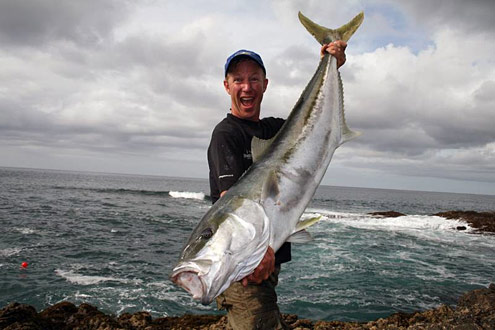

In [11]:
Image("data/mf.jpg")

In the above code to load the pretrained ResNet model, after the model is loaded we call `model.eval()`. Why is this? What happens if you don't make this call before using the model? __Write your answers in the following block:__


switch the model into the evaluation mode. If we don't make this call, then we will continue to train the model using the testing data.


We're now in a position to start to hack the model structure. Fundamentally we need to first remove the classification layer at the end of the model and replace it with a new one (with a different number of classes). Let's print out the model structure:

In [12]:
# print(model)

Looking at the model we can see that really what we want to do is just replace the last fully connected layer with one with a different number of features. There are many ways in which PyTorch allows us to do this, but the simplest is to just do a direct replacement. 

We'll also make a small change to the pooling layer before the last fully connected layer; in the default ResNet model 2D average pooling is used to reduce a 2048x7x7 tensor to 2048x1x1 by using a 7x7 pooling window. This is precisely the definition of Global Average Pooling, however it is implemented with a fixed size window. As our boat images are not square, it would be nice if we could use them at a high resolution without cropping. We can replace the pooling layer with an `nn.AdaptiveAvgPool2d` layer that will perform real Global Average Pooling by dynamically scaling the window to whatever spatial size the input feature maps have:

# Unfreeze FC

In [61]:
# Step1: initialize model
model_ft = resnet50(pretrained=True)

model_ft.avgpool = nn.AdaptiveAvgPool2d((1,1))

model_ft.fc = nn.Linear(2048, len(train_dataset.classes))

# model_ft.train()


The actual process of finetuning involves us now training the model with our own data. As the network is already largely trained, we'll likely want to use a small learning rate so not to make big changes in weights. Often we'll first "freeze" the weights of the already trained layers whilst we learn initial weights for our new layer to avoid overfitting while training:

In [62]:
# Step2: Freeze layers by not tracking gradients
for param in model_ft.parameters():
    param.requires_grad = False

model_ft.fc.weight.requires_grad = True # unfreeze last layer weights
model_ft.fc.bias.requires_grad = True #unfreeze last layer biases

# create optimizer
optimiser = optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=1e-4) #only optimse non-frozen layers

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Number of epochs to train for 
num_epochs = 15


If we have lots of training data we could then unlock these layers and perform end-to-end finetuning afterwards. The Standford CS231n course pages have lots of useful hints on fine-tuning: http://cs231n.github.io/transfer-learning/

__Use the following block to try finetuning the resnet50 with the boat data. You'll need a GPU to do this effectively as it's _rather_ slow!__

In [63]:
# Step3: 
# the number of images that will be processed in a single step
batch_size=128

image_size=(30, 100)

data_transforms = {
    'train': transforms.Compose([
        # transforms.Resize(224),
        # transforms.CenterCrop(224),
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        # transforms.Resize(224),
        # transforms.CenterCrop(224),
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        # transforms.Resize(224),
        # transforms.CenterCrop(224),
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: ImageFolder("data/" + x, data_transforms[x]) for x in ['train', 'valid', 'test'] }

# Create training and validation dataloaders
dataloaders_dict = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'valid', 'test'] }



Initializing Datasets and Dataloaders...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [64]:
# https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/finetuning_torchvision_models_tutorial.ipynb
# https://www.kaggle.com/frozenwolf/coronahack-finetuning-resnet18-pytorch
import matplotlib.pyplot as plt
import time
import copy

def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    since = time.time()

    val_acc_history = []
    train_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'valid':
                val_acc_history.append(epoch_acc)
            if phase == 'train':
                train_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, train_acc_history, val_acc_history


In [65]:
# Step4: 

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Send the model to GPU
model_ft = model_ft.to(device)

# Train and evaluate
model_ft, train_acc_history, val_acc_history = train_model(model_ft, 
                                                           dataloaders_dict, 
                                                           criterion, 
                                                           optimiser, 
                                                           num_epochs=num_epochs)


Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 2.3012 Acc: 0.2283
valid Loss: 2.0695 Acc: 0.3722

Epoch 1/14
----------
train Loss: 1.8680 Acc: 0.5049
valid Loss: 1.8428 Acc: 0.5696

Epoch 2/14
----------
train Loss: 1.6639 Acc: 0.6235
valid Loss: 1.6935 Acc: 0.6329

Epoch 3/14
----------
train Loss: 1.5235 Acc: 0.6485
valid Loss: 1.5859 Acc: 0.6456

Epoch 4/14
----------
train Loss: 1.4181 Acc: 0.6641
valid Loss: 1.5024 Acc: 0.6582

Epoch 5/14
----------
train Loss: 1.3332 Acc: 0.6730
valid Loss: 1.4318 Acc: 0.6633

Epoch 6/14
----------
train Loss: 1.2690 Acc: 0.6750
valid Loss: 1.3720 Acc: 0.6684

Epoch 7/14
----------
train Loss: 1.2059 Acc: 0.6908
valid Loss: 1.3304 Acc: 0.6709

Epoch 8/14
----------
train Loss: 1.1570 Acc: 0.6946
valid Loss: 1.2934 Acc: 0.6759

Epoch 9/14
----------
train Loss: 1.1163 Acc: 0.7047
valid Loss: 1.2588 Acc: 0.6810

Epoch 10/14
----------
train Loss: 1.0749 Acc: 0.7170
valid Loss: 1.2248 Acc: 0.6861

Epoch 11/14
----------
train Loss: 1.0399 Acc: 0.7162
valid Loss: 1.1953 Acc: 0.6886



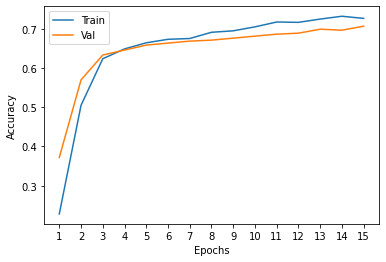

In [66]:
import numpy as np

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.plot(range(1, num_epochs+1), train_acc_history, label="Train")
plt.plot(range(1, num_epochs+1), val_acc_history, label="Val")

plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()


In [213]:
def evaluation(dataloader):
  model_ft.eval()
  
  test_corrects = 0
  y_pred = []
  y_test = []
  
  for inputs, labels in dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)
    
    y_pred += preds.tolist()
    y_test += labels.data.tolist()

    test_corrects += torch.sum(preds == labels.data)

  acc = test_corrects.double() / len(dataloader.dataset)
  
  return y_pred, y_test, acc


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.7628398791540786


In [214]:
from sklearn import metrics

test_predicted, test_target, acc = evaluation(dataloaders_dict['test'])

print(metrics.classification_report(test_target, test_predicted, target_names=train_dataset.classes))


                         precision    recall  f1-score   support

              Alilaguna       1.00      0.32      0.48        19
              Ambulanza       0.71      0.23      0.34        22
               Barchino       0.17      0.02      0.04        51
                Gondola       0.00      0.00      0.00         3
          Lanciafino10m       0.00      0.00      0.00         7
              Motobarca       0.11      0.02      0.03        59
Motopontonerettangolare       0.00      0.00      0.00         3
          MotoscafoACTV       0.00      0.00      0.00         1
               Mototopo       0.55      0.93      0.69       274
              Patanella       0.50      0.41      0.45        74
                Polizia       0.00      0.00      0.00        15
        Raccoltarifiuti       0.57      0.21      0.31        19
           Sandoloaremi       0.00      0.00      0.00         3
                   Topa       0.00      0.00      0.00        29
          VaporettoACTV 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Unfreeze other layers

In [219]:
for name, child in model_ft.named_children():
    print(name)
    if name in ['layer3', 'layer4']:
      for param in child.parameters():
        param.requires_grad = True
    else:
        param.requires_grad = False

# create optimizer
optimiser = optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=1e-3) #only optimse non-frozen layers


conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [220]:
# Step4: 

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Send the model to GPU
model_ft = model_ft.to(device)

# Train and evaluate
model_ft, train_acc_history, val_acc_history = train_model(model_ft, 
                                                           dataloaders_dict, 
                                                           criterion, 
                                                           optimiser, 
                                                           num_epochs=num_epochs)


Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.7043 Acc: 0.7956
valid Loss: 1.0031 Acc: 0.7696

Epoch 1/14
----------
train Loss: 0.3696 Acc: 0.8725
valid Loss: 0.5323 Acc: 0.8152

Epoch 2/14
----------
train Loss: 0.2530 Acc: 0.9131
valid Loss: 0.5839 Acc: 0.8506

Epoch 3/14
----------
train Loss: 0.1684 Acc: 0.9442
valid Loss: 0.7149 Acc: 0.8228

Epoch 4/14
----------
train Loss: 0.1919 Acc: 0.9398
valid Loss: 0.5582 Acc: 0.8582

Epoch 5/14
----------
train Loss: 0.1066 Acc: 0.9695
valid Loss: 0.6365 Acc: 0.8684

Epoch 6/14
----------
train Loss: 0.0856 Acc: 0.9796
valid Loss: 0.5384 Acc: 0.8633

Epoch 7/14
----------
train Loss: 0.1422 Acc: 0.9594
valid Loss: 0.6042 Acc: 0.8430

Epoch 8/14
----------
train Loss: 0.2198 Acc: 0.9401
valid Loss: 0.4964 Acc: 0.8582

Epoch 9/14
----------
train Loss: 0.0626 Acc: 0.9799
valid Loss: 0.4971 Acc: 0.8835

Epoch 10/14
----------
train Loss: 0.0926 Acc: 0.9727
valid Loss: 0.4485 Acc: 0.8861

Epoch 11/14
----------
train Loss: 0.0421 Acc: 0.9879
valid Loss: 0.6151 Acc: 0.8734



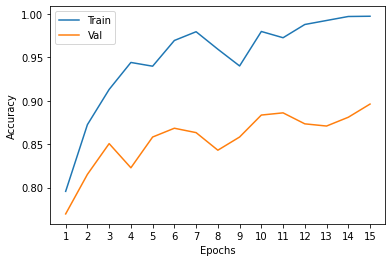

In [221]:
import numpy as np

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.plot(range(1, num_epochs+1), train_acc_history, label="Train")
plt.plot(range(1, num_epochs+1), val_acc_history, label="Val")

plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()


In [222]:
from sklearn import metrics

test_predicted, test_target, acc = evaluation(dataloaders_dict['test'])

print(metrics.classification_report(test_target, test_predicted, target_names=train_dataset.classes))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


                         precision    recall  f1-score   support

              Alilaguna       1.00      0.95      0.97        19
              Ambulanza       1.00      0.95      0.98        22
               Barchino       0.76      0.25      0.38        51
                Gondola       0.67      0.67      0.67         3
          Lanciafino10m       0.17      0.14      0.15         7
              Motobarca       0.59      0.54      0.57        59
Motopontonerettangolare       0.75      1.00      0.86         3
          MotoscafoACTV       1.00      1.00      1.00         1
               Mototopo       0.94      0.93      0.93       274
              Patanella       0.53      0.85      0.65        74
                Polizia       0.67      0.67      0.67        15
        Raccoltarifiuti       0.90      0.95      0.92        19
           Sandoloaremi       0.67      0.67      0.67         3
                   Topa       0.38      0.17      0.24        29
          VaporettoACTV 


Use the following block to note down the performance you achieve by finetuning the model. How does this compare to the `BetterCNN` model used earlier?

YOUR ANSWER HERE

## Extracting features from a model

Sometimes you want to do things that are not so easily accomplished with a deep network. You might want to build classifiers using very small amounts of data, or you might want a way of finding things in photographs that are in some way semantically similar, but don't have exactly the same classes. CNNs can actually help here using a technique known often called transfer learning (and related to the fine tuning that we just looked at). If we assume we have a trained network, then by extracting vectors from the layers before the final classifier we should have a means of achieving these tasks, as the vectors are likely to strongly encode semantic information about the content of the input image. If we wanted to quickly train new classifiers for new classes, we could for instance just use a relatively simple linear classifier trained on these vectors. If we wanted to find semantically similar images, we could just compare the Euclidean distance of these vectors.

PyTorch makes it pretty easy to get these vector representations. The following code gets a resnet model in which the a feature vector is computed from the penultimate layer of the network by applying a _global average pooling_ operation over the feature maps:

In [68]:
from torch import nn

model = resnet50(pretrained=True)

feature_extractor_model = nn.Sequential(*list(model.children())[:-2], nn.AdaptiveAvgPool2d((1,1)))
feature_extractor_model.eval()
feature_extractor_model = feature_extractor_model.to(device)


With this model, extract the features for some inputs. To demonstrate, we can put the whole thing together and generate a vector from an image:

In [69]:
transform = transforms.Compose([
    transforms.Resize((240, 800)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

img_path = 'data/test/Alilaguna/20130412_064059_20202.jpg'
img = PImage.open(img_path)

feature = feature_extractor_model(preprocess_input(img).unsqueeze(0).to(device))

print('Feature shape:', feature.shape)
print('Feature data:', feature[0].reshape(-1))

Feature shape: torch.Size([1, 2048, 1, 1])
Feature data: tensor([0.2288, 0.6563, 0.0540,  ..., 0.0110, 0.6035, 0.1322], device='cuda:0',
       grad_fn=<ViewBackward>)


Use the following block to generate some features for some different images in the test set, and calculate the Euclidean distances between these features. 

In [132]:
# YOUR CODE HERE
import os
from os.path import isfile, join, isdir
import numpy as np

classes = [ dirs for dirs in os.listdir("./data/test") if isdir(join('./data/test', dirs)) ]
img_class_path = {}
for c in classes:
  img_class_path.setdefault(c, [])
  for f in os.listdir("./data/test/" + c):
    if isfile(join("./data/test/" + c, f)):
      img_class_path[c].append(join("./data/test/" + c, f))


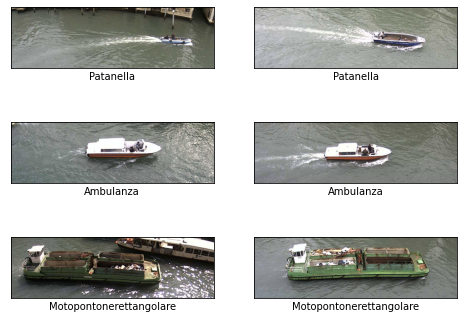

In [165]:
transform = transforms.Compose([
    transforms.Resize((240, 800)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])
selected_img_path = []
img_class_feature = {}
selected_classes = np.random.choice(classes, 3)
for c in selected_classes:
  for img_path in np.random.choice(img_class_path[c], 2):
    selected_img_path.append(img_path)
    img = PImage.open(img_path)
    feature = feature_extractor_model(preprocess_input(img).unsqueeze(0).to(device))
    img_class_feature.setdefault(c, [])
    img_class_feature[c].append(feature[0].reshape(-1))

from PIL import Image
fig,ax=plt.subplots(3, 2, figsize=(8, 6))
for i, img_path in enumerate(selected_img_path):
  img = Image.open(img_path)
  ax[i//2, i%2].imshow(img)
  ax[i//2, i%2].set_xlabel(selected_classes[i//2])
  ax[i//2, i%2].set_xticks([])
  ax[i//2, i%2].set_yticks([])


In [166]:
dist = []
for c in selected_classes:
  dist_c = [c]
  for c2 in selected_classes:
    dist_c.append(torch.cdist(img_class_feature[c][0].reshape(1, -1), img_class_feature[c2][1].reshape(1, -1), 2).item())
  
  dist.append(dist_c)

from IPython.display import HTML, display
import tabulate
display(HTML(tabulate.tabulate(dist, tablefmt='html')))


Patanella,13.3019,16.623,19.4121
Ambulanza,15.9037,11.8774,19.8927
Motopontonerettangolare,18.9756,18.1311,16.2956


In the following block describe how the Euclidean distances compare to your perception of similarity between the images:

YOUR ANSWER HERE

Let's now explore how features from a ResNet could be used with a classifier that works well with small amounts of training data - a Support Vector Machine. Use the following block to train a multiclass SVM using the `sklearn.svm.SVC` class to learn the boat classes using the features extracted by the ResNet50 with the default imagenet weights. Once you've trained it (and optimised the parameters) print out a classification report. 

We've provided all the features and labels in the form of `numpy` arrays so you don't have to extract them (which can take a few minutes; you can view the code we used [here](https://github.com/ecs-vlc/COMP6248/blob/master/docs/labs/lab6/genfeats.py)):

In [168]:
import numpy as np

if not exists('training_features.npy'):
    !wget -O Resnet50Features.zip https://artist-cloud.ecs.soton.ac.uk/index.php/s/P68OB07DquOwSR7/download
    !unzip Resnet50Features.zip

training_features = np.load('training_features.npy')
training_labels = np.load('training_labels.npy')

valid_features = np.load('valid_features.npy')
valid_labels = np.load('valid_labels.npy')

testing_features = np.load('testing_features.npy')
testing_labels = np.load('testing_labels.npy')


In [172]:
# YOUR CODE HERE
training_features.shape, training_labels.shape, np.unique(training_labels)


((3474, 2048),
 (3474,),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]))

In [176]:
from sklearn.svm import SVC

since = time.time()

classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(training_features, training_labels)
print('training time: ', time.time() - since )

testing_predicted = classifier.predict(testing_features)
print('test acc:', np.sum(testing_predicted == testing_labels)/len(testing_labels))
print('prediction time: ', time.time() - since )


training time:  12.776823282241821
test acc: 0.8716012084592145
prediction time:  17.908647298812866


In [185]:
from sklearn import metrics

print(metrics.classification_report(testing_labels, testing_predicted, target_names=train_dataset.classes))


                         precision    recall  f1-score   support

              Alilaguna       0.90      1.00      0.95        19
              Ambulanza       0.82      0.82      0.82        22
               Barchino       0.76      0.25      0.38        51
                Gondola       1.00      0.67      0.80         3
          Lanciafino10m       0.00      0.00      0.00         7
              Motobarca       0.82      0.31      0.44        59
Motopontonerettangolare       1.00      1.00      1.00         3
          MotoscafoACTV       0.00      0.00      0.00         1
               Mototopo       0.82      0.99      0.89       274
              Patanella       0.41      0.84      0.55        74
                Polizia       0.67      0.13      0.22        15
        Raccoltarifiuti       1.00      0.74      0.85        19
           Sandoloaremi       0.00      0.00      0.00         3
                   Topa       0.00      0.00      0.00        29
          VaporettoACTV 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Use the following block to reflect on how the test performance compares to the finetuned ResNet. What is the difference in time taken to train and evaluate the different approaches?

YOUR ANSWER HERE